#NYC Street Trees

I'll be analyzing New York City Department of Parks data from the last street tree census; this includes a record of all trees that were planted in Manhattan, Brooklyn, Queens and the Bronx as recorded in 2005. I'll look at the distribution of tree species, what neighborhoods have a larger percentage of older trees, and the relationship between tree and human population density.

In [1]:
#Setup
import pandas as pd
import numpy as np
import seaborn as sb
import statsmodels.formula.api as sm
%matplotlib inline

In [2]:
# Read in tree datasets for each borough as well as geographic and demographic
# data detailing population density by zip and land use by census block
# (which I'll use to answer question #3)
geo_data = []
tree_data = []
boroughs = ['Manhattan', 'Brooklyn', 'Bronx', 'Queens']

def filter_residential(x):
    return x[x['LandUse'] < 5][['LandUse']].count()
def filter_parks(x):
    return x[x['LandUse'] == 9][['LandUse']].count()

for b in boroughs:
    data = pd.read_csv(b + 'LandUse.csv', sep=',',
                      usecols=['Borough', 'Block', 'ZipCode', 'LandUse'])
    by_zip = data.groupby('ZipCode')
    land_use_entries = by_zip[['LandUse']].count()
    residential = by_zip.apply(filter_residential) / land_use_entries
    residential = residential.reset_index()
    parks = by_zip.apply(filter_parks) / land_use_entries
    parks = parks.reset_index()
    merged_geo = residential.merge(parks, how='inner', on='ZipCode')
    merged_geo.columns = ['ZIPCODE', 'RESIDENTIAL', 'PARKS']
    geo_data.append(merged_geo)
    tree_data.append(pd.read_csv(b + '.csv', sep=','))

In [3]:
# Concatenate data for all boroughs into two DataFrames
# (one for the tree listings, one for the geographic data)
trees = pd.concat(tree_data)
geo = pd.concat(geo_data)
# Add population density to the geographic data
pop = pd.read_csv('Zips.csv', sep=',', usecols=['Zip/ZCTA', 'Land-Sq-Mi', 'Density Per Sq Mile'])
pop.columns = ['ZIPCODE', 'AREA', 'DENSITY']
geo = geo.merge(pop, how='left', on='ZIPCODE')

species = pd.read_csv('TreeNames.csv', sep=',')
species.columns = ['SPECIES', 'COMNAME']
trees = trees.merge(species, how='left', on='SPECIES')

In [5]:
trees.head(2)

,BOROUGH,BUILDINGNU,BUILDINGST,COMMDIST,CROSSSTREE,CROSSSTR_1,DIAMETER,FID_1,OBJECTID,OBJECTID_1,ONSTREET,PARITY,SITE,SPECIES,TREECONDIT,TREEID,TREELOCATI,TREEPIT,ZIPCODE,COMNAME
0,Manhattan,74A,TRINITY PLACE,101,THAMES STREET,RECTOR PLACE,6,0,NaN,16,TRINITY PLACE,odd,4,PYCA,1,186,1,1,10006,"PEAR, CALLERY"
1,Manhattan,74,TRINITY PLACE,101,THAMES STREET,RECTOR PLACE,5,0,NaN,17,TRINITY PLACE,odd,4,PYCA,1,188,1,1,10006,"PEAR, CALLERY"


##How much of the total distribution of trees is accounted for by the most common species? Do the same species dominate in all/most neighborhoods?

In [6]:
#Get total species count for each zip code
species_dist = trees.groupby(['BOROUGH', 'ZIPCODE', 'COMNAME'])[['COMNAME']].count()
species_dist.columns = ['NUMBER']
species_dist = species_dist.reset_index()

In [7]:
#Looking at the most common common species in each neighborhood,
# it's clear that a few species tend to dominate.
most_common_by_zip = species_dist.ix[species_dist.groupby(['BOROUGH', 'ZIPCODE'])['NUMBER'].idxmax()]
for b in boroughs:
    print(b)
    print(most_common_by_zip[most_common_by_zip['BOROUGH'] == b].head(4)[['ZIPCODE', 'COMNAME']])

Manhattan
      ZIPCODE        COMNAME
3717    10001  PEAR, CALLERY
3736    10002    HONEYLOCUST
3779    10003    HONEYLOCUST
3816    10004    HONEYLOCUST
Brooklyn
      ZIPCODE           COMNAME
1406    11201  LONDON PLANETREE
1473    11203  LONDON PLANETREE
1543    11204  LONDON PLANETREE
1603    11205  LONDON PLANETREE
Bronx
     ZIPCODE      COMNAME
11     10451  HONEYLOCUST
51     10452  HONEYLOCUST
97     10453  HONEYLOCUST
140    10454  HONEYLOCUST
Queens
      ZIPCODE        COMNAME
5122    11001  MAPLE, NORWAY
5180    11004  MAPLE, NORWAY
5215    11005     ASH, GREEN
5237    11040  MAPLE, NORWAY


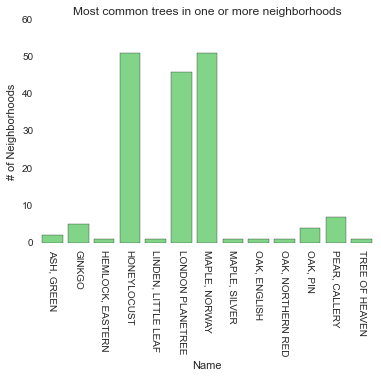

In [8]:
# This histogram plots species that are the most commonly found trees in at least one neighborhood, as well as the
# number of zip codes in which they predominate. Three species vastly outpace the rest.
dist_top_species = most_common_by_zip.groupby('COMNAME')[['NUMBER']].count().reset_index()
distplot = sb.barplot(x='COMNAME',y='NUMBER', data=dist_top_species, color='#82D489')
distplot.set_title('Most common trees in one or more neighborhoods')
distplot.set_xlabel('Name')
distplot.set_ylabel('# of Neighborhoods')
_ = distplot.set_xticklabels(dist_top_species['COMNAME'], rotation=-90)

In [9]:
# A few of the neighborhoods with an unusual #1 tree are outliers of sorts in that they have very small tree
# populations to begin with.
print(most_common_by_zip[most_common_by_zip['COMNAME'] == 'TREE OF HEAVEN'])
print(most_common_by_zip[most_common_by_zip['COMNAME'] == 'HEMLOCK, EASTERN'])

     BOROUGH  ZIPCODE         COMNAME  NUMBER
8881  Queens    11697  TREE OF HEAVEN       7
     BOROUGH  ZIPCODE           COMNAME  NUMBER
1356   Bronx    10803  HEMLOCK, EASTERN      15


However, 11239, for example, is somewhat unusual in that Little Leaf Lindens far outpace Honeylocusts.

In [10]:
zip_w_lindens = int(most_common_by_zip[most_common_by_zip['COMNAME'] == 'LINDEN, LITTLE LEAF']['ZIPCODE'])
species_dist[species_dist['ZIPCODE'] == zip_w_lindens].sort('NUMBER', ascending=False)[:5]

,BOROUGH,ZIPCODE,COMNAME,NUMBER
3686,Brooklyn,11239,"LINDEN, LITTLE LEAF",70
3693,Brooklyn,11239,UNKOWN,32
3685,Brooklyn,11239,HONEYLOCUST,20
3692,Brooklyn,11239,"PEAR, CALLERY",17
3690,Brooklyn,11239,"OAK, NORTHERN RED",9


By looking at the cumulative sum of the species totals, we can see that the five most common (London Planetree, Norway Maple, Honeylocust, Callery Pear, and Pin Oak) make up more than 50% of the data, and the first 12 make up approximately 80% - there are a total of 118 distinct species recorded in the dataset.

In [11]:
species_count = trees.groupby(['COMNAME'])[['COMNAME']].count()
species_count.columns = ['NUMBER']
species_count = species_count.reset_index()

In [12]:
species_count = species_count[species_count['COMNAME'] != 'UNKOWN'].sort(['NUMBER'], ascending=False)

In [13]:
species_cum = species_count[['NUMBER']].cumsum() / species_count[['NUMBER']].sum()

In [14]:
species_count['CUMULATIVE PERCENTAGE'] = species_cum
species_count[:12]

,COMNAME,NUMBER,CUMULATIVE PERCENTAGE
57,LONDON PLANETREE,80140,0.169150
64,"MAPLE, NORWAY",67388,0.311384
43,HONEYLOCUST,48746,0.414272
87,"PEAR, CALLERY",39158,0.496922
78,"OAK, PIN",37098,0.575224
54,"LINDEN, LITTLE LEAF",25988,0.630076
3,"ASH, GREEN",17001,0.665960
34,GINKGO,15685,0.699066
118,"ZELKOVA, JAPANESE",13226,0.726981
68,"MAPLE, SILVER",13186,0.754813


## What neighborhoods have the highest percentage of older trees?

I assume that tree diameter gives a reliable estimate of tree age and look at what percentage of the trees in each zip code are above the median diameter for that species

In [15]:
#Find the median diameter for each tree species
median_diam = trees.groupby(['COMNAME'])[['DIAMETER']].median().reset_index()

In [16]:
median_diam.columns = ['COMNAME', 'MEDIANDIAM']

In [17]:
trees_with_mdiam = trees.merge(median_diam, how='left', on='COMNAME')

In [18]:
#Find the percentage of trees in each zip code that are larger than the median diameter for that species
percent_large = pd.DataFrame(trees_with_mdiam.groupby(['BOROUGH', 'ZIPCODE'])\
[['DIAMETER', 'MEDIANDIAM']].apply(lambda x: x[x['DIAMETER'] > x['MEDIANDIAM']]\
.count())['DIAMETER'] / trees_with_mdiam.groupby(['BOROUGH', 'ZIPCODE'])['MEDIANDIAM'].count())

In [19]:
percent_large = percent_large.reset_index()
percent_large.columns = ['BOROUGH', 'ZIPCODE', 'PERCENTLARGE']

In [20]:
percent_large.sort(['PERCENTLARGE'], ascending=False).head(5)

,BOROUGH,ZIPCODE,PERCENTLARGE
104,Manhattan,10162,0.866667
144,Queens,11412,0.728170
147,Queens,11415,0.675900
159,Queens,11429,0.660277
155,Queens,11423,0.629202


Most of these are residential neighborhoods in Outer Queens

##How strongly is the density of trees in a neighborhood correlated with the population density in that area?

In [21]:
count_by_zip = trees.groupby(['BOROUGH', 'ZIPCODE'])[['COMNAME']].count().reset_index()

In [22]:
#Merge in geographic data
trees_and_geo = count_by_zip.merge(geo, how='left', on='ZIPCODE')

In [23]:
#Calculate the number of trees per square mile in each zip code
trees_and_geo['TDENSITY'] = trees_and_geo['COMNAME'] / trees_and_geo['AREA']

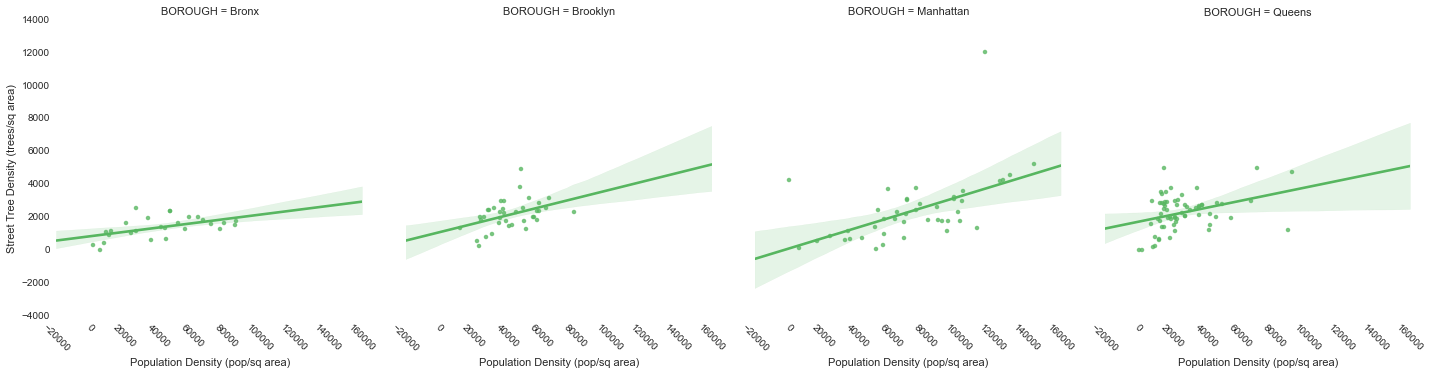

In [24]:
# Plot population density against tree density
density = sb.lmplot(x='DENSITY', y='TDENSITY', col='BOROUGH', data=trees_and_geo, color='#57B660')
density.set_xlabels('Population Density (pop/sq area)').set_ylabels('Street Tree Density (trees/sq area)')
_ = density.set_xticklabels(rotation=-45)

Population density isn't very strongly correlated with tree density - the R-squared for these is 0.27, 0.18, 0.28 and 0.13.

I also tried including the percentage of blocks in the neighborhood that were classified as residential (or mixed-residential/commercial) during the last census, and included an interaction effect with population density. I also suspected that areas with a higher percentage of blocks that were classified as Parks Department property might have an effect. Building these factors into the model did result in a higher R-squared for each neighborhood.

In [26]:
for b in ['Manhattan', 'Brooklyn', 'Bronx', 'Queens']:
    d = trees_and_geo[trees_and_geo['BOROUGH'] == b]
    stats = sm.ols('TDENSITY ~ DENSITY*RESIDENTIAL + PARKS', data=d).fit()
    residuals = stats.resid
    
    print(b, "R-squared: %s" % stats.rsquared)


Manhattan R-squared: 0.480571894925
Brooklyn R-squared: 0.386785959468
Bronx R-squared: 0.633852540289
Queens R-squared: 0.273495466168
